# Exercise 1. DL2 files and PINT

In [1]:
import pandas as pd
import os
import numpy as np
from astropy.time import Time
import pint
import astropy.units as u
from astropy.io import fits
import pint.toa as toa
import time
from lstchain.io.io import dl2_params_lstcam_key
import pint.models as models
from pint.models.timing_model import (
        TimingModel,
        Component,
)
from pint.models import (
        parameter as p,
)

### 1.1 Download the most updated ephemeris from the Jodrell Bank web and create a .par file with the model for the month corresponding for the file in /LSTpulsar_data/notebook1 and for the previous month

In [2]:
data_dir='/fefs/aswg/workspace/alvaro.mas/LSTpulsar_data'
eph_file=data_dir+'/notebook1/all.gro'
file=data_dir+'/notebook1/DL2/dl2_LST-1.Run02976.0000.h5'

In [3]:
df=pd.read_hdf(file,key=dl2_params_lstcam_key,float_precision=20)
times=df.dragon_time.values
t = Time(times,format='unix', scale='utc')
mjd_times=t.mjd

In [4]:
colnames=['PSR', 'RAJ1','RAJ2','RAJ3', 'DECJ1','DECJ2','DECJ3', 'START', 'FINISH', 't0geo', 'F0', 'F1', 'F2',
              'RMS','Observatory', 'EPHEM', 'PSR2']

df_ephem= pd.read_csv(eph_file, delimiter='\s+',names=colnames,header=None)

In [5]:
#Looking for the information for the epoch of the times
for i in range(0,len(df_ephem['START'])):
        if (mjd_times[0]>df_ephem['START'][i]) & (mjd_times[0]<df_ephem['FINISH'][i]):
            break
        elif (mjd_times[0]< df_ephem['START'][i]) & (i==0):
            print('No ephemeris available')
        elif (mjd_times[0]> df_ephem['START'][i]) & (mjd_times[0]> df_ephem['FINISH'][i])& (i==len(df_ephem['START'])):
            print('No ephemeris available')

In [6]:
i

416

#### Execute the following bloc for i=i and i=i-1

In [8]:
#Select componentes of the model
all_components = Component.component_types
selected_components = ["AbsPhase","AstrometryEquatorial", "Spindown","SolarSystemShapiro"]
component_instances = []

# Initiate the component instances (see PINT pulsar documentation)
for cp_name in selected_components:
    component_class = all_components[cp_name]  # Get the component class
    component_instance = component_class()  # Instantiate a component object
    component_instances.append(component_instance)
    
tm = TimingModel("pulsar_test", component_instances)


#Add first derivative of the frequency
f1 = p.prefixParameter(
        parameter_type="float",
        name="F1",
        value=0.0,
        units=u.Hz / (u.s),
        longdouble=True,
)

#Add second derivative of the frequency
f2 = p.prefixParameter(
        parameter_type="float",
        name="F2",
        value=0.0,
        units=u.Hz / (u.s)**2,
        longdouble=True,
)

tm.components["Spindown"].add_param(f1, setup=True)
tm.components["Spindown"].add_param(f2, setup=True)

f1=float(str(df_ephem['F1'][i].replace('D','E')))
f2=float(str(df_ephem['F2'][i].replace('D','E')))

#Give values to the parameters
params = {
            "PSR":(df_ephem['PSR'][i],) ,
            "RAJ": (str(df_ephem['RAJ1'][i])+':'+ str(df_ephem['RAJ2'][i])+':'+str(df_ephem['RAJ3'][i]),),
            "DECJ": (str(df_ephem['DECJ1'][i])+':'+ str(df_ephem['DECJ2'][i])+':'+str(df_ephem['DECJ3'][i]),),
            "START": (Time(df_ephem['START'][i], format="mjd", scale="tdb"),),
            "FINISH": (Time(df_ephem['FINISH'][i], format="mjd", scale="tdb"),),
            "EPHEM":(df_ephem['EPHEM'][i],),
            'PEPOCH':(Time(int(df_ephem['t0geo'][i]), format="mjd", scale="tdb"),),
            "F0": (df_ephem['F0'][i]*u.Hz,),
            "F1": (f1*u.Hz/u.s,),
            "F2":(f2*u.Hz/(u.s**2),),
            "TZRMJD":(Time(df_ephem['t0geo'][i], format="mjd", scale="tdb"),),
            "TZRFRQ":(0.0*u.Hz,),
            "TZRSITE":('coe',),
        }

#Create the model using PINT
for name, info in params.items():
        par = getattr(tm, name)  # Get parameter object from name
        par.quantity = info[0]  # set parameter value
        if len(info) > 1:
                if info[1] == 1:
                        par.frozen = False  # Frozen means not fit.
                        par.uncertainty = info[2]

tm.validate()
print(tm)

INFO     (pint.models.absolute_phase    ): TZRFRQ was 0.0 or None. Setting to infinite frequency.


# Created: 2022-06-06T15:16:09.619514
# PINT_version: 0.8.8
# User: alvaro.mas
# Host: cp01
# OS: Linux-3.10.0-957.el7.x86_64-x86_64-with-centos-7.6.1810-Core
# Format: pint
PSR                               0531+21
EPHEM                               DE200
START              59154.0000000000000000
FINISH             59184.0000000000000000
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
CHI2                                  0.0
RAJ                      5:34:31.97200000
DECJ                    22:00:52.07000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                  29.601561703284300364
F1                           -3.67917e-10
F2                              -7.12e-21
PEPOCH             59169.0000000000000000
TZRMJD             59169.0000001689986675
TZRSITE                               coe
TZRFRQ                      

In [9]:
#Create the .par file
tm.as_parfile()
parname=str(os.path.basename(file).replace('.h5',''))+'_'+str(i)+'.par'
f=open(parname,"w+")
f.write(tm.as_parfile())
f.close()

### 1.2. Create the .tim file for this file 

In [10]:
timname=str(os.path.basename(file).replace('.h5',''))+'.tim'
timFile=open(timname,'w+')
timFile.write('FORMAT 1 \n')
for i in range(0,len(mjd_times)):
    timFile.write('lst '+'0.0 '+str(mjd_times[i])+' 0.0 '+ 'lst'+' \n')
timFile.close()

In [11]:
timname

'dl2_LST-1.Run02976.0000.tim'

In [12]:
!head ./dl2_LST-1.Run02976.0000.tim

FORMAT 1 
lst 0.0 59174.15089879001 0.0 lst 
lst 0.0 59174.15089879721 0.0 lst 
lst 0.0 59174.1508987976 0.0 lst 
lst 0.0 59174.150898798856 0.0 lst 
lst 0.0 59174.1508987999 0.0 lst 
lst 0.0 59174.150898806074 0.0 lst 
lst 0.0 59174.150898807995 0.0 lst 
lst 0.0 59174.15089880979 0.0 lst 
lst 0.0 59174.1508988108 0.0 lst 


### 1.3 Execute the scrit add_pulsarphase.py directly to the DL2 file to obtain the DL2_pulsar file. Do it using both models. Compare the phases obtained with both models and calculate the mean different between both phases for the events

In [13]:
!add_pulsarphase --in-file /fefs/aswg/workspace/alvaro.mas/data/real/Crab/src_dependent/v0.9_crab/DL2/dl2_LST-1.Run02976.0000.h5  --ephem ./dl2_LST-1.Run02976.0000_416.par --output ./

^C
Traceback (most recent call last):
  File "/fefs/aswg/workspace/alvaro.mas/software/miniconda3/envs/pulsar-lst1/bin/add_pulsarphase", line 5, in <module>
    from ptiming_ana.cphase.add_pulsarphase import main
  File "/fefs/aswg/workspace/alvaro.mas/software/miniconda3/envs/pulsar-lst1/lib/python3.7/site-packages/ptiming_ana/__init__.py", line 1, in <module>
    from . import cphase
  File "/fefs/aswg/workspace/alvaro.mas/software/miniconda3/envs/pulsar-lst1/lib/python3.7/site-packages/ptiming_ana/cphase/__init__.py", line 2, in <module>
    from .pulsarphase_cal import calphase,fermi_calphase
  File "/fefs/aswg/workspace/alvaro.mas/software/miniconda3/envs/pulsar-lst1/lib/python3.7/site-packages/ptiming_ana/cphase/pulsarphase_cal.py", line 18, in <module>
    from lstchain.reco import dl1_to_dl2
  File "/fefs/aswg/workspace/alvaro.mas/software/miniconda3/envs/pulsar-lst1/lib/python3.7/site-packages/lstchain/reco/dl1_to_dl2.py", line 18, in <module>
    from sklearn.ensemble import 

In [14]:
phases_1=pd.read_hdf('dl2_LST-1.Run02976.0000_pulsar.h5',key=dl2_params_lstcam_key,float_precision=20)['pulsar_phase']

FileNotFoundError: File dl2_LST-1.Run02976.0000_pulsar.h5 does not exist

In [ ]:
!rm dl2_LST-1.Run02976.0000_pulsar.h5

In [ ]:
!add_pulsarphase --in-file /fefs/aswg/workspace/alvaro.mas/data/real/Crab/src_dependent/v0.9_crab/DL2/dl2_LST-1.Run02976.0000.h5  --ephem ./dl2_LST-1.Run02976.0000_417.par --output ./

In [38]:
phases_2=pd.read_hdf('dl2_LST-1.Run02976.0000_pulsar.h5',key=dl2_params_lstcam_key,float_precision=20)['pulsar_phase']

In [58]:
phases_1-phases_2

0        0.006896
1        0.006896
2        0.006896
3        0.006896
4        0.006896
           ...   
42592    0.006896
42593    0.006896
42594    0.006896
42595    0.006896
42596    0.006896
Name: pulsar_phase, Length: 42597, dtype: float128

--------------------------------------------------------------------------

### 1.4 For the merged file in LSTpulsar_data/notebook2 build the phaseogram with 60 bins and get the P1/P2 ratio. Use a gammaness_cut>0.4 and alpha_cut<15 for E<100 GeV and gammaness_cut>0.6 and alpha_cut<10 for E>100 GeV

In [24]:
from ptiming_ana.phaseogram import *

In [42]:
h=PulsarAnalysis()
h.setLSTInputFile(filename=data_dir+'/notebook2/pulsar_sample.h5')
h.setBackgroundLimits([0.52,0.87])
h.setPeaklimits(P1_limits=[0,0.026,0.983,1],P2_limits=[0.377,0.422],P3_limits=[0.026,0.377])
h.setBinning(nbins=50,xmin=0,xmax=1)
h.setTimeInterval(tint=3600*50)
h.setParamCuts(gammaness_cut=[0.4,0.6],alpha_cut=[15,10],zd_cut=35,energy_binning_cut=[0.01,0.1,1000])
h.setFittingParams(model='lorentzian',binned=False)
h.setEnergybinning([0,0.1,100])

In [ ]:
h.run()

--> Initializing...
    Reading LST-1 data file
    Finishing reading. Total time is 5.350203256474601 h
    Finishing filtering events:
        gammaness cut:[0.4, 0.6]
        alpha cut:[15, 10]
        theta2 cut:None
        zd cut:35
        energy binning for the cuts:[0.01, 0.1, 1000]


--> Calculating statistics every 3000.0 minutes...
--> Fitting the data to the given model...
    Fit model: lorentzian
    Binned fitting: False

--> Performing energy-dependent analysis...
Creating object in energy range (TeV):0.00-0.10
Calculating statistics...
--> Fitting the data to the given model...
    Fit model: lorentzian
    Binned fitting: False


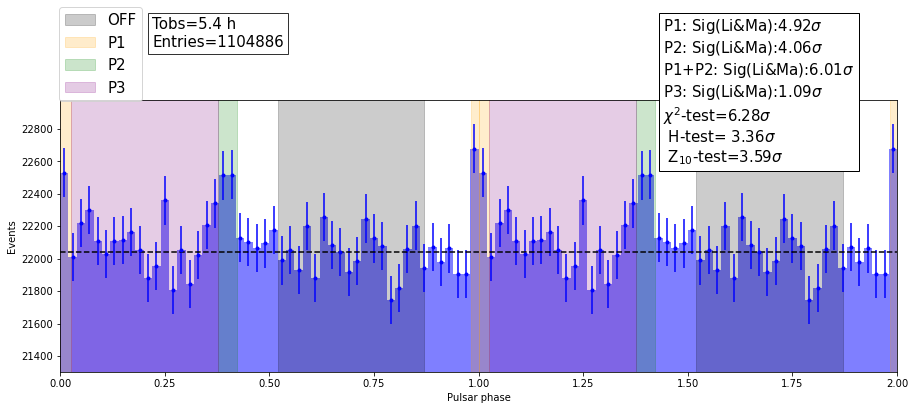

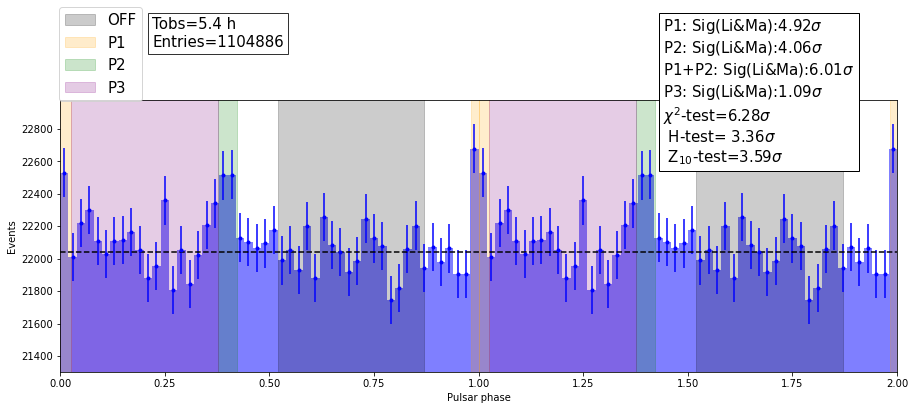

In [37]:
h.draw_phaseogram(phase_limits=[0,2],colorhist='blue')

### 1.5 Check the Nexcess and the significance of the P1, P2 and the bridge defined as the region between P1 and P2

In [38]:
peak_stats,period_stats=h.show_Presults()

RESULTS FOR THE PEAK STATISTICS:

                        P1            P2         P1+P2             P3
Significance      4.923191      4.058082      6.013987       1.085039
Nex            1140.428571    963.285714   2103.714286     955.428571
Nex_error       233.082484    238.552672    351.304789     880.547154
Number        48508.000000  50534.000000  99042.000000  387607.000000
noff          47367.571429  49570.714286  96938.285714  386651.571429
sign_t_ratio      2.147306      1.769979      2.623069       0.473252
s/n ratio         5.239955      4.326558      6.756769       1.536520

P1/P2 ratio=1.18+/-0.38


 
RESULTS FOR THE PERIODICITY SEARCH:

                    Chi_square_test    Zn_test     H_test
Statistic                 83.118081  50.925207  19.705761
p-value                    0.001684   0.000163   0.000393
Number of $\sigma$         6.280817   3.593637   3.358008


### 1.6 Calculate the significance of each peak at E>100GeV and E<100 GeV

In [39]:
sp,ss=h.show_EnergyPresults()

ENERGY RANGE (TeV):0.00-0.10

RESULTS FOR THE PEAK STATISTICS:

                        P1            P2         P1+P2             P3
Significance      4.170681      3.541725      5.165413       0.851040
Nex             937.180000    815.700000   1752.880000     727.260000
Nex_error       225.925280    231.339722    340.638722     854.553360
Number        45560.000000  47514.000000  93074.000000  364974.000000
noff          44622.820000  46698.300000  91321.120000  364246.740000
sign_t_ratio      1.827267      1.551707      2.263081       0.372859
s/n ratio         4.436541      3.774678      5.800515       1.205013

P1/P2 ratio=1.15+/-0.43


 
RESULTS FOR THE PERIODICITY SEARCH:

                    Chi_square_test    Zn_test     H_test
Statistic                 77.445059  45.414867  11.945653
p-value                    0.005914   0.000969   0.008614
Number of $\sigma$         6.082569   3.099545   2.381807

 

-------------------------------------------------------------------
ENERGY

### 1.7 Try to fit the phaseogram to a Double Lorentzian Distibution

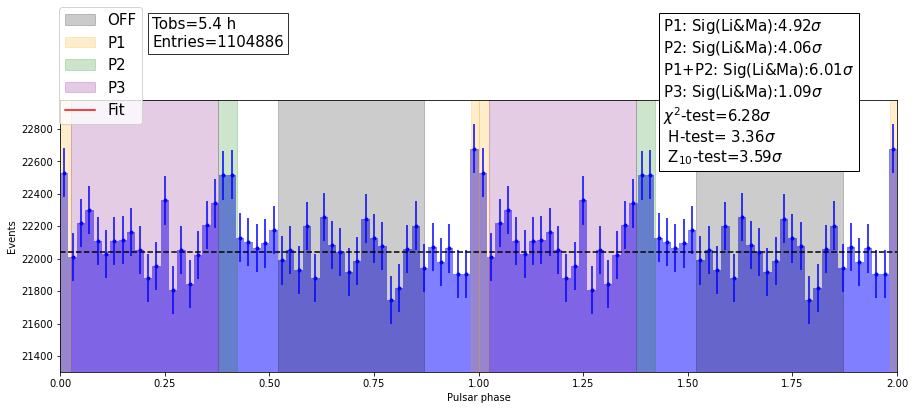

In [40]:
histo=h.draw_phaseogram(phase_limits=[0,2],colorhist='blue',fit=True)

In [41]:
res=h.show_fit_results()

      Name         Value         Error
0     mu_1 -10772.710124  9.272461e+09
1  gamma_1 -35253.885491  8.858680e+09
2     mu_2  65666.716005  1.836312e+10
3  gamma_2 -17849.668087  4.105085e+09
4        A    121.518607           NaN
5        B    -77.058740  5.845643e+02
6        C    -44.454368           NaN
